# GP kernel parameter optimization/ inference 

Slightly modified from 

https://tinygp.readthedocs.io/en/latest/tutorials/modeling.html

(We simplify the code by not passing the `yerr` variable to the model, and rename the input `t` (for time) to `x`, to make it more generic.) 

In [15]:
try:
    import tinygp
except ImportError:
    !pip install -q tinygp
    
try:
    import numpyro
except ImportError:
    !pip uninstall -y jax jaxlib
    !pip install -q numpyro jax jaxlib

try:
    import arviz
except ImportError:
    
    
try:
    import flax
except ImportError:
    !pip install -q flax
    
try:
    import optax
except ImportError:
    !pip install -q optax


!pip install -q blackjax distrax

from jax.config import config

config.update("jax_enable_x64", True)

# Data


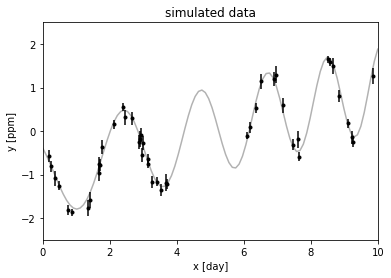

In [2]:
import numpy as np
import matplotlib.pyplot as plt

random = np.random.default_rng(42)

t = np.sort(
    np.append(
        random.uniform(0, 3.8, 28),
        random.uniform(5.5, 10, 18),
    )
)
yerr = random.uniform(0.08, 0.22, len(t))
y = (
    0.2 * (t - 5)
    + np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * random.normal(size=len(t))
)

true_t = np.linspace(0, 10, 100)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

x = t
x_test = true_t
y_test = true_y

plt.plot(x_test, y_test, "k", lw=1.5, alpha=0.3)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

plt.savefig('gp-kernel-opt-data.pdf')



# Optimizing hyper-parameters using flax & optax

We  find the maximum (marginal) likelihood hyperparameters for the GP model.


To set up our model, we define a custom `linen.Module`, and optimize it's parameters as follows:

In [3]:
from tinygp import kernels, GaussianProcess

import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.linen.initializers import zeros

import optax


class GPModule(nn.Module):
    @nn.compact
    def __call__(self, x, y, t):
        # t = test input locations
        # Returns loss (-log p(y|x)) and predictions p(y|t)
        mean = self.param("mean", zeros, ())
        log_jitter = self.param("log_jitter", zeros, ())

        log_sigma1 = self.param("log_sigma1", zeros, ())
        log_rho1 = self.param("log_rho1", zeros, ())
        log_tau = self.param("log_tau", zeros, ())
        kernel1 = (
            jnp.exp(2 * log_sigma1)
            * kernels.ExpSquared(jnp.exp(log_tau))
            * kernels.Cosine(jnp.exp(log_rho1))
        )

        log_sigma2 = self.param("log_sigma2", zeros, ())
        log_rho2 = self.param("log_rho2", zeros, ())
        kernel2 = jnp.exp(2 * log_sigma2) * kernels.Matern32(jnp.exp(log_rho2))

        kernel = kernel1 + kernel2
        gp = GaussianProcess(
            kernel, x, diag=jnp.exp(log_jitter), mean=mean
        )

        loss = -gp.condition(y)
        pred = gp.predict(y, t)

        return loss, pred


def loss(params):
    return model.apply(params, x, y, x_test)[0]



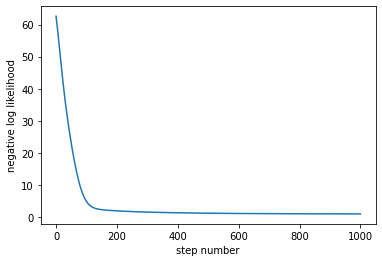

In [4]:

model = GPModule()
params = model.init(jax.random.PRNGKey(0), x,  y, x_test)
tx = optax.sgd(learning_rate=3e-3)
opt_state = tx.init(params)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))

losses = []
for i in range(1001):
    loss_val, grads = loss_grad_fn(params)
    losses.append(loss_val)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

plt.plot(losses)
plt.ylabel("negative log likelihood")
_ = plt.xlabel("step number")

Our `Module` defined above also returns the conditional predictions, that we can compare to the true model:

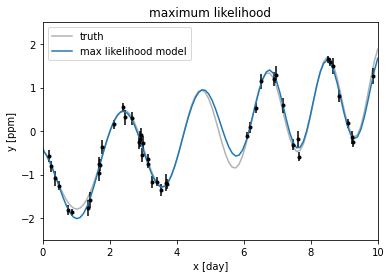

In [5]:
pred = model.apply(params, x,  y, x_test)[1]

plt.plot(x_test, y_test, "k", lw=1.5, alpha=0.3, label="truth")
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_test, pred, label="max likelihood model")
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
plt.legend()
_ = plt.title("maximum likelihood")
plt.savefig('gp-kernel-opt-eb.pdf')


# Inferring hyper-parameters using HMC in numpyro

We can compute a posterior over the kernel parameters, and hence the posterior predictive over the mean function, using HMC.

In [6]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

prior_sigma = 5.0

def numpyro_model(x, y, x_test_inputs): 
    mean = numpyro.sample("mean", dist.Normal(0.0, prior_sigma))
    jitter = numpyro.sample("jitter", dist.HalfNormal(prior_sigma))

    sigma1 = numpyro.sample("sigma1", dist.HalfNormal(prior_sigma))
    rho1 = numpyro.sample("rho1", dist.HalfNormal(prior_sigma))
    tau = numpyro.sample("tau", dist.HalfNormal(prior_sigma))
    kernel1 = sigma1 ** 2 * kernels.ExpSquared(tau) * kernels.Cosine(rho1)

    sigma2 = numpyro.sample("sigma2", dist.HalfNormal(prior_sigma))
    rho2 = numpyro.sample("rho2", dist.HalfNormal(prior_sigma))
    kernel2 = sigma2 ** 2 * kernels.Matern32(rho2)

    kernel = kernel1 + kernel2
    gp = GaussianProcess(kernel, x, diag=jitter, mean=mean)
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.predict(y, x_test_inputs))


nuts_kernel = NUTS(numpyro_model, dense_mass=True, target_accept_prob=0.9)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=200,
    num_samples=500,
    num_chains=2,
    progress_bar=False,
)
rng_key = jax.random.PRNGKey(34923)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.


In [7]:
%%time
mcmc.run(rng_key, x, y, x_test)
samples = mcmc.get_samples()
pred = samples["pred"].block_until_ready()  # Blocking to get timing right

CPU times: user 59.1 s, sys: 32.2 s, total: 1min 31s
Wall time: 1min 12s


Let's examine the posterior. 
For that task, let's use [`ArviZ`](https://arviz-devs.github.io):

In [ ]:
import arviz as az

data = az.from_numpyro(mcmc)
az.summary(
    data, var_names=[v for v in data.posterior.data_vars if v != "pred"]
)

And, finally we can plot our posterior inferences of the comditional process, compared to the true model:

In [10]:
def plot_posterior_inference(pred, file_name):
  q = np.percentile(pred, [5, 50, 95], axis=0)
  plt.fill_between(x_test, q[0], q[2], color="C0", alpha=0.5, label="inference")
  plt.plot(x_test, q[1], color="C0", lw=2)
  plt.plot(x_test, y_test, "k", lw=1.5, alpha=0.3, label="truth")

  plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
  plt.xlabel("x [day]")
  plt.ylabel("y [ppm]")
  plt.xlim(0, 10)
  plt.ylim(-2.5, 2.5)
  plt.legend()
  _ = plt.title("posterior inference")
  plt.savefig(f'{file_name}.pdf')

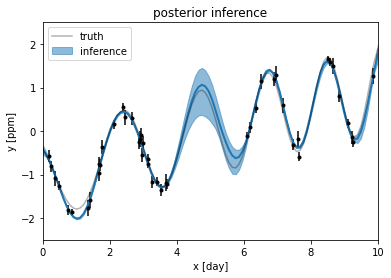

In [11]:
plot_posterior_inference(pred, "gp-kernel-opt-numpyro")

# Inferring hyper-parameters using HMC in BlackJax

In [17]:
import blackjax, distrax
from blackjax import nuts
from blackjax import stan_warmup

from jax import vmap
from jax.random import split, PRNGKey

from functools import partial

import tensorflow_probability.substrates.jax.distributions as tfd

In [18]:
prior_sigma = 5.
half_normal_dist = distrax.as_distribution(tfd.HalfNormal(prior_sigma))

In [19]:
def init_model_params(x, y, rng_key):
    dtype = x.dtype
    params = {}

    rng_key, mean_key, jitter_key = split(rng_key, 3)
    params["mean"] = distrax.Normal(0, prior_sigma).sample(seed=mean_key, sample_shape=()).astype(dtype)
    params["jitter"] =  half_normal_dist.sample(seed=jitter_key, sample_shape=()).astype(dtype)
    
    rng_key, sigma1_key, rho1_key, tau_key = split(rng_key, 4)
    params["sigma1"] =  half_normal_dist.sample(seed=sigma1_key, sample_shape=()).astype(dtype)
    params["rho1"] =  half_normal_dist.sample(seed=rho1_key, sample_shape=()).astype(dtype)
    params["tau"] =  half_normal_dist.sample(seed=tau_key, sample_shape=()).astype(dtype)
    
    sigma2_key, rho2_key = split(rng_key)
    params["sigma2"] =  half_normal_dist.sample(seed=sigma2_key, sample_shape=()).astype(dtype)
    params["rho2"] =  half_normal_dist.sample(seed=rho2_key, sample_shape=()).astype(dtype)
    return params

In [20]:
def model(params, x, y, x_test_inputs=None):
    kernel1 = params["sigma1"] ** 2 * kernels.ExpSquared(params["tau"]) * kernels.Cosine(params["rho1"])
    kernel2 = params["sigma2"] ** 2 * kernels.Matern32(params["rho2"])
    
    kernel = kernel1 + kernel2
    gp = GaussianProcess(kernel, x, diag=params["jitter"], mean=params["mean"])

    pred = None
    if x_test_inputs is not None:
      pred = gp.predict(y, x_test_inputs)
    else:
      pred = gp.predict(y)
    return pred, gp.condition(y)

In [21]:
def logprob_fn(params, x, y, model):
    log_joint = 0
        
    log_joint += jnp.nan_to_num(distrax.Normal(0, prior_sigma).log_prob(params["mean"]))
    log_joint += jnp.nan_to_num(half_normal_dist.log_prob(params["jitter"]))
    log_joint += jnp.nan_to_num(half_normal_dist.log_prob(params["sigma1"]))
    log_joint += jnp.nan_to_num(half_normal_dist.log_prob(params["rho1"]))
    log_joint += jnp.nan_to_num(half_normal_dist.log_prob(params["tau"]))
    log_joint += jnp.nan_to_num(half_normal_dist.log_prob(params["sigma2"]))
    log_joint += jnp.nan_to_num(half_normal_dist.log_prob(params["rho2"]))
    
    _, likelihood = model(params, x, y)
    return log_joint + jnp.nan_to_num(likelihood)

In [22]:
def inference_loop_multiple_chains(rng_key, kernel, initial_state, num_samples, num_chains):
    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, _ = jax.vmap(kernel)(keys, states)
        return states, states

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [23]:
def fit_and_eval(rng_key, model, potential_fn, x, y, x_test, n_chains=1):
    init_key, warmup_key, inference_key = split(rng_key, 3)

    # initialization
    potential = partial(potential_fn, x=x, y=y, model=model)
    initial_position = init_model_params(x, y, init_key)
    dummy_state = nuts.new_state(initial_position, potential)
    initial_states = vmap(lambda _:dummy_state)(jnp.arange(n_chains))
    kernel_generator = lambda step_size, inverse_mass_matrix: nuts.kernel(potential, step_size, inverse_mass_matrix)

    # warm up
    final_state, (step_size, inverse_mass_matrix), info = stan_warmup.run(warmup_key, kernel_generator, dummy_state, num_warmup, 
                                                                          target_acceptance_rate=target_acceptance_rate, is_mass_matrix_diagonal=False)

    # inference
    nuts_kernel = jax.jit(kernel_generator(step_size, inverse_mass_matrix))
    states = inference_loop_multiple_chains(inference_key, nuts_kernel, initial_states, num_samples, n_chains)
    samples = states.position
    # evaluation
    model = partial(model, x=x, y=y, x_test_inputs=x_test)
    predictions, log_likelihoods = vmap(vmap(model))(samples)
    return predictions

In [24]:
rng_key = jax.random.PRNGKey(34923)
num_warmup=200
num_samples=500
n_chains = 2
target_acceptance_rate = 0.9

In [25]:
%%time
predictions = fit_and_eval(rng_key, model, logprob_fn, x, y, x_test, n_chains)

CPU times: user 2min 34s, sys: 1min 10s, total: 3min 44s
Wall time: 2min 36s


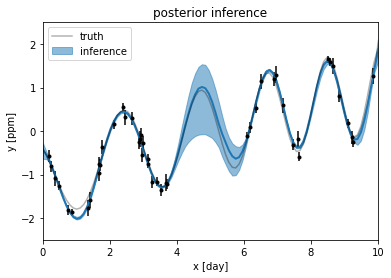

In [26]:
pred = predictions.reshape((n_chains * num_samples, -1))
plot_posterior_inference(pred, "gp-kernel-opt-blackjax")